<a href="https://colab.research.google.com/github/quangnhat1395/MLEF1/blob/master/UEL_MLEF1_Linear_Regression_Logistics_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np # Linear algebra
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt  # Matlab-style plotting
# Make sure plot shows immediately
%matplotlib inline 

import seaborn as sns # Library for plotting
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats # Library for scientific computation
from scipy.stats import norm, skew # For some statistics

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 1. Linear Regression

In [ ]:
import numpy as np # Linear algebra
import pandas as pd # Data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt  # Matlab-style plotting
# Make sure plot shows immediately
%matplotlib inline 

import seaborn as sns # Library for plotting
color = sns.color_palette()
sns.set_style('darkgrid')

from scipy import stats # Library for scientific computation
from scipy.stats import norm, skew # For some statistics

In [ ]:
"""
Read data from CSV file and calculate some statistic.
The outcome/label/dependent variable is SalePrice.
The others are features/independent variable.
"""

train = 'https://github.com/SrikanthVelpuri/House-Prices-Advanced-Regression-Techniques/raw/master/train.csv'
df = pd.read_csv(train)
print(df.shape)
df.describe()

(1460, 81)


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
# Drop filed `Id` which is not useful for model
df = df.drop(columns=['Id'])

## 1.1. Exploratory data analysis

### The target
#### The distribution


 mu = 180921.20 and sigma = 79415.29



Text(0.5, 1.0, 'SalePrice distribution')

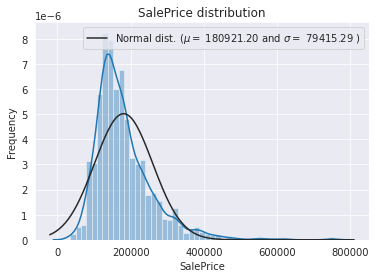

In [ ]:
sns.distplot(df['SalePrice'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

### Outlier removing

In [ ]:
df = df[(np.abs(stats.zscore(df.SalePrice)) < 3)]

### Missing values
#### Calculating the rate of missing value

In [ ]:
df_na = (df.isnull().sum() / len(df)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'miss_rate' :df_na})
missing_data.head(20)

,miss_rate
PoolQC,99.582754
MiscFeature,96.244784
Alley,93.671766
Fence,80.598053
FireplaceQu,47.983310
LotFrontage,17.872045
GarageYrBlt,5.632823
GarageType,5.632823
GarageFinish,5.632823
GarageQual,5.632823


In [ ]:
missing_col_drop = list(missing_data[missing_data.miss_rate>10].index)

In [ ]:
df_non_na = df.drop(columns=missing_col_drop)

In [ ]:
# Calculate mean for every NUMERIC data field
means = df_non_na._get_numeric_data().mean()

# Fill NA by mean on NUMERIC data
df_non_na._get_numeric_data().fillna(means, inplace=True)

In [ ]:
# Check missing values
df_na = (df_non_na.isnull().sum() / len(df_non_na)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'miss_rate' :df_na})
missing_data.head(20)

,miss_rate
GarageCond,5.632823
GarageQual,5.632823
GarageFinish,5.632823
GarageType,5.632823
BsmtFinType2,2.642559
BsmtExposure,2.642559
BsmtFinType1,2.573018
BsmtCond,2.573018
BsmtQual,2.573018
MasVnrType,0.486787


In [ ]:
# Find the mode of NON-NUMERIC data
modes = df_non_na.mode()

# Fill NA by mode on NON-NUMERIC data field
df_non_na = df_non_na.fillna(modes.to_dict(orient='records')[0])


In [ ]:
# Check missing values again
df_na = (df_non_na.isnull().sum() / len(df_non_na)) * 100
df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'miss_rate' :df_na})
missing_data.head(20)

,miss_rate


## 1.2. Remove highly correlated variables

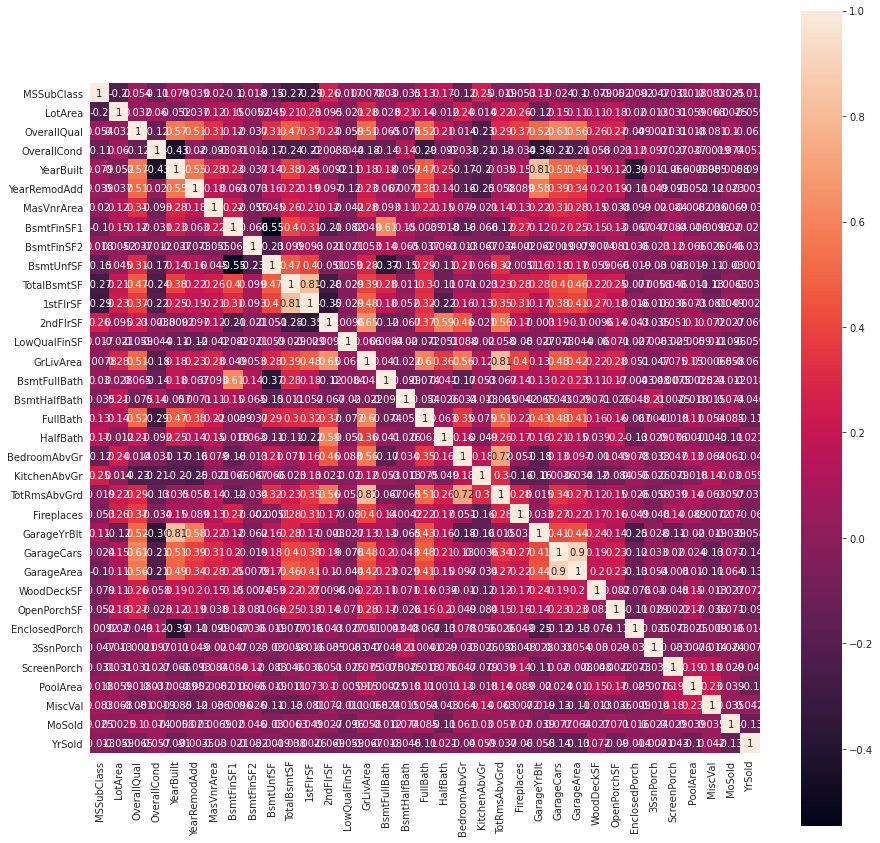

In [ ]:
# Calculate the Correlation matrix of data frame without Dependent variable 
# (Just on 25% of data to speed up the calculation)
corr_matrix = df_non_na.drop(columns=['SalePrice'])._get_numeric_data().sample(frac=0.25).corr()

# Plot the heatmap of Correlation
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, vmax=1, annot=True, square=True);
plt.show()

In [ ]:
# Create correlation matrix
corr_matrix = corr_matrix.abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.8
to_drop_corr = [column for column in upper.columns if any(upper[column] >= 0.8)]
print(to_drop_corr)

['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']


In [ ]:
train_df = df_non_na.drop(columns=to_drop_corr)
train_df.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,Functional,Fireplaces,GarageType,GarageFinish,GarageCars,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,854,0,1710,1,0,2,1,3,1,Gd,Typ,0,Attchd,RFn,2,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,0,0,1262,0,1,2,0,3,1,TA,Typ,1,Attchd,RFn,2,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,866,0,1786,1,0,2,1,3,1,Gd,Typ,1,Attchd,RFn,2,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,756,0,1717,1,0,1,0,3,1,Gd,Typ,1,Detchd,Unf,3,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1053,0,2198,1,0,2,1,4,1,Gd,Typ,1,Attchd,RFn,3,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


## 1.3. Normalize the numerical features

In [ ]:
num_cols = train_df.drop(columns=['SalePrice']).select_dtypes(include='number').columns
print(num_cols)
train_df[num_cols].head()

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'Fireplaces', 'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold'],
      dtype='object')


,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,60,8450,7,5,2003,2003,196.0,706,0,150,856,854,0,1710,1,0,2,1,3,1,0,2,0,61,0,0,0,0,0,2,2008
1,20,9600,6,8,1976,1976,0.0,978,0,284,1262,0,0,1262,0,1,2,0,3,1,1,2,298,0,0,0,0,0,0,5,2007
2,60,11250,7,5,2001,2002,162.0,486,0,434,920,866,0,1786,1,0,2,1,3,1,1,2,0,42,0,0,0,0,0,9,2008
3,70,9550,7,5,1915,1970,0.0,216,0,540,756,756,0,1717,1,0,1,0,3,1,1,3,0,35,272,0,0,0,0,2,2006
4,60,14260,8,5,2000,2000,350.0,655,0,490,1145,1053,0,2198,1,0,2,1,4,1,1,3,192,84,0,0,0,0,0,12,2008


In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_df = scaler.fit_transform(train_df[num_cols])

In [ ]:
train_df[num_cols] = scaled_df
train_df.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000
mean,0.218011,0.042541,0.561273,0.572583,0.716268,0.576182,0.061142,0.076611,0.031809,0.241214,0.170664,0.186848,0.010485,0.218697,0.140241,0.028860,0.517385,0.188456,0.357876,0.349096,0.200510,0.437239,0.108339,0.083496,0.039967,0.006814,0.030434,0.003273,0.002849,0.484764,0.455146,175844.522253
std,0.250177,0.046486,0.148250,0.139438,0.218066,0.344206,0.105401,0.078434,0.109858,0.187471,0.068887,0.234687,0.088363,0.093310,0.172864,0.119592,0.180120,0.250856,0.101421,0.073981,0.213348,0.184467,0.145351,0.119788,0.110722,0.058145,0.113727,0.051177,0.032250,0.245635,0.331701,67475.861228
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,0.000000,0.028979,0.444444,0.500000,0.588768,0.266667,0.000000,0.000000,0.000000,0.093857,0.129787,0.000000,0.000000,0.149209,0.000000,0.000000,0.333333,0.000000,0.250000,0.333333,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.363636,0.250000,129500.000000
50%,0.176471,0.037860,0.555556,0.500000,0.724638,0.716667,0.000000,0.066974,0.000000,0.203339,0.160966,0.000000,0.000000,0.211379,0.000000,0.000000,0.666667,0.000000,0.375000,0.333333,0.333333,0.500000,0.000000,0.043876,0.000000,0.000000,0.000000,0.000000,0.000000,0.454545,0.500000,161500.000000
75%,0.294118,0.047400,0.666667,0.625000,0.927536,0.900000,0.098594,0.123804,0.000000,0.345034,0.208306,0.400440,0.000000,0.268981,0.333333,0.000000,0.666667,0.500000,0.375000,0.333333,0.333333,0.500000,0.196033,0.120658,0.000000,0.000000,0.000000,0.000000,0.000000,0.636364,0.750000,210000.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,415298.000000


## 1.4. Categorical variable handling

In [ ]:
train_df = pd.get_dummies(train_df, drop_first=True)
train_df.head()


,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,...,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageFinish_RFn,GarageFinish_Unf,GarageQual_Fa,GarageQual_Gd,GarageQual_Po,GarageQual_TA,GarageCond_Fa,GarageCond_Gd,GarageCond_Po,GarageCond_TA,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.235294,0.033420,0.666667,0.500,0.949275,0.883333,0.12250,0.125089,0.0,0.064212,0.140098,0.469747,0.0,0.259231,0.333333,0.0,0.666667,0.5,0.375,0.333333,0.000000,0.50,0.000000,0.111517,0.000000,0.0,0.0,0.0,0.0,0.090909,0.50,208500,0,0,1,0,1,0,0,1,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.000000,0.038795,0.555556,0.875,0.753623,0.433333,0.00000,0.173281,0.0,0.121575,0.206547,0.000000,0.0,0.174830,0.000000,0.5,0.666667,0.0,0.375,0.333333,0.333333,0.50,0.347725,0.000000,0.000000,0.0,0.0,0.0,0.0,0.363636,0.25,181500,0,0,1,0,1,0,0,1,...,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0.235294,0.046507,0.666667,0.500,0.934783,0.866667,0.10125,0.086109,0.0,0.185788,0.150573,0.476348,0.0,0.273549,0.333333,0.0,0.666667,0.5,0.375,0.333333,0.333333,0.50,0.000000,0.076782,0.000000,0.0,0.0,0.0,0.0,0.727273,0.50,223500,0,0,1,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0
3,0.294118,0.038561,0.666667,0.500,0.311594,0.333333,0.00000,0.038271,0.0,0.231164,0.123732,0.415842,0.0,0.260550,0.333333,0.0,0.333333,0.0,0.375,0.333333,0.333333,0.75,0.000000,0.063985,0.492754,0.0,0.0,0.0,0.0,0.090909,0.00,140000,0,0,1,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0.235294,0.060576,0.777778,0.500,0.927536,0.833333,0.21875,0.116052,0.0,0.209760,0.187398,0.579208,0.0,0.351168,0.333333,0.0,0.666667,0.5,0.500,0.333333,0.333333,0.75,0.224037,0.153565,0.000000,0.0,0.0,0.0,0.0,1.000000,0.50,250000,0,0,1,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0


## 1.5. Feature selection

Why Feature selection?

![alt text](https://www.fast.ai/images/overfitting2.png)

In [ ]:
# Feature Importance
# Using Random Forest to calculate the Feature importance
# After that, the Feature importance was used to rank and select features

from sklearn import datasets
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

# fit an Extra Trees model to the data
model = RandomForestRegressor()
model.fit(train_df.drop(columns=['SalePrice']), train_df.SalePrice)
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = train_df.drop(columns=['SalePrice']).columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

In [ ]:
feature_importances.head()

,importance
OverallQual,0.583761
GrLivArea,0.114472
TotalBsmtSF,0.054459
GarageCars,0.048963
BsmtFinSF1,0.031449


In [ ]:
# For this example, only top-2 features was used to build the model

ft = list(feature_importances[:2].index)
print(ft)

['OverallQual', 'GrLivArea']


## 1.6. Training/Test splitting

In [ ]:
"""
Split the dataframe into 2 part
* Training dataset (60%)
* Test dataset (40%)

The model will be trained on training dataset and evaluate on test dataset
"""

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df[ft], train_df.SalePrice, test_size=0.4, random_state=42)

## 1.7. Linear regression -- scikit-learn

In [ ]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# Create linear regression object
regr = linear_model.LinearRegression()
# Train the model using the training sets
regr.fit(X_train, y_train)

# Predict on Test set
y_pred = regr.predict(X_test)

# Evaluation on Test set
print(f'R-squared = {r2_score(y_test, y_pred):.4f}')
print(f'RMSE       = {mean_squared_error(y_test, y_pred)**0.5:.2f}')

R-squared = 0.7188
RMSE       = 34635.44


In [ ]:
print(regr.coef_)
print(regr.intercept_)

[294385.76324964 207429.44169987]
-34450.019859232794


## 1.8. Linear regression -- Gradient descent approach

In [ ]:
x = X_train
x = np.c_[np.ones(x.shape[0]), x]
y = y_train

x_test = np.c_[np.ones(X_test.shape[0]), X_test]

In [ ]:
alpha = 0.1 #Step size
iterations = 10 #No. of iterations
m = y.size #No. of data points
np.random.seed(123) #Set the seed
theta = np.random.rand(x.shape[1]) #Pick some random values to start with

#GRADIENT DESCENT
def gradient_descent(x, y, theta, iterations, alpha):
    past_costs = []
    past_test_costs = []
    past_thetas = [theta]
    for i in range(iterations):
        # Training
        prediction = np.dot(x, theta)
        error = prediction - y
        cost = 1/(2*m) * np.dot(error.T, error)
        past_costs.append(cost)
        theta = theta - (alpha * (1/m) * np.dot(x.T, error))
        past_thetas.append(theta)

        # Testing
        test_pred = np.dot(x_test, theta)
        test_error = test_pred - y_test
        test_cost = 1/(2*m) * np.dot(test_error.T, test_error)
        past_test_costs.append(test_cost)
        
    return past_thetas, past_costs, past_test_costs

In [ ]:
#Pass the relevant variables to the function and get the new values back...
past_thetas, past_costs, past_test_costs = gradient_descent(x, y, theta, iterations, alpha)
theta = past_thetas[-1]

#Print the results...
print(f"Gradient Descent: {theta}")

Gradient Descent: [98502.40464064 62866.04929064 25839.92599766]


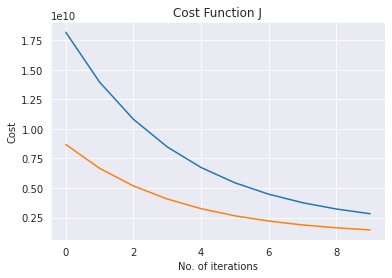

In [ ]:
#Plot the cost function...
plt.title('Cost Function J')
plt.xlabel('No. of iterations')
plt.ylabel('Cost')
plt.plot(past_costs)
plt.plot(past_test_costs)
plt.show()

In [ ]:
print(f'R-squared   = {r2_score(y_test, y_pred):.4f}')
print(f'RMSE        = {mean_squared_error(y_test, y_pred)**0.5:.4f}')

R-squared   = 0.7188
RMSE        = 34635.4423


## 1.9. Linear regression - Ridge

The Ridge regression can be used to select feature and fit model.

This method optimized the loss function including the Ridge/Tikhonov regularization

$$\min_{w} \frac{1}{2n_{\text{samples}}} || X w - y||_2^2 + \alpha ||w||_2^2$$

The $\alpha$ need to be tuned.

More info: https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression-and-classification

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(columns=['SalePrice']), 
                                                    train_df.SalePrice, 
                                                    test_size=0.4, 
                                                    random_state=42)

print(f"Training shape: {X_train.shape}")
print(f"Testing shape: {X_test.shape}")

Training shape: (862, 228)
Testing shape: (576, 228)


In [ ]:
# The linear model WITHOUT Ridge
# A full dataset (not only top-2 features) was used to fit the model
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print(f'R-squared   = {r2_score(y_test, y_pred):.4f}')
print(f'RMSE        = {mean_squared_error(y_test, y_pred)**0.5:.4f}')

R-squared   = -25155678168137146368.0000
RMSE        = 327595297256508.5000


If we don't use Ridge regularization, the model with full data was too bad, the r-squared < 0 means that chosen model does not follow the trend of the data

In [ ]:
# The linear model WITH Ridge
# A full dataset (not only top-2 features) was used to fit the model

ridge_regr = linear_model.Ridge()
ridge_regr.fit(X_train, y_train)
y_pred_ridge = ridge_regr.predict(X_test)
print(f'R-squared   = {r2_score(y_test, y_pred_ridge):.4f}')
print(f'RMSE        = {mean_squared_error(y_test, y_pred_ridge)**0.5:.4f}')

R-squared   = 0.7163
RMSE        = 34789.4750


The Ridge still worked well with high-dimensional dataset

## 1.10. Linear regression - Lasso

The Lasso regression optimized the loss function including Lasso regularization

$$\min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha ||w||_1}$$

The $\alpha$ need to be tuned.

More info: https://scikit-learn.org/stable/modules/linear_model.html#lasso

In [ ]:
lasso_regr = linear_model.Lasso()
lasso_regr.fit(X_train, y_train)
y_pred_lasso = lasso_regr.predict(X_test)
print(f'R-squared   = {r2_score(y_test, y_pred_lasso):.4f}')
print(f'RMSE        = {mean_squared_error(y_test, y_pred_lasso)**0.5:.4f}')

R-squared   = 0.7188
RMSE        = 34636.4603


## 1.11. Linear regression - ElasticNet

The ElasticNet method combines both Ridge and Lass regularization

$$\min_{w} { \frac{1}{2n_{\text{samples}}} ||X w - y||_2 ^ 2 + \alpha \rho ||w||_1 +
\frac{\alpha(1-\rho)}{2} ||w||_2 ^ 2}$$

The $\alpha$ and $\rho$ need to be tuned.

More info: https://scikit-learn.org/stable/modules/linear_model.html#elastic-net

In [ ]:
en_regr = linear_model.ElasticNet()
en_regr.fit(X_train, y_train)
y_pred_en = en_regr.predict(X_test)
print(f'R-squared = {r2_score(y_test, y_pred_en):.4f}')
print(f'RMSE        = {mean_squared_error(y_test, y_pred_en)**0.5:.4f}')

R-squared = 0.0639
RMSE        = 63195.5578


# 2. Logistic Regression

Demo of Logistic Regression on Breast cancer dataset

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry 
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 3 is Mean Radius, field
        13 is Radius SE, field 23 is Worst Radius.

        - class:
                - WDBC-Malignant
                - WDBC-Benign

## 2.1. Data Loading & PreProcessing

In [ ]:
# Load data
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

In [ ]:
# Scaling the features using Min-Max scaler
X = data['data']
scl = MinMaxScaler()
scl.fit(X)
X_scaled = scl.transform(X)

In [ ]:
y = data['target']

In [ ]:
# Split data into train-test with ratio 60:40
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.4)

In [ ]:
X_train.shape

(341, 30)

In [ ]:
X_test.shape

(228, 30)

## 2.2. Model training

In [ ]:
# Initiate the Logistic regression model and fit the data
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

## 2.3. Results

In [ ]:
# Print the metrics of classifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97        94
           1       0.96      1.00      0.98       134

    accuracy                           0.97       228
   macro avg       0.98      0.97      0.97       228
weighted avg       0.97      0.97      0.97       228



In [ ]:
# Print the AUC score
y_score = logreg.decision_function(X_test)
auc_score = roc_auc_score(y_test, y_score)
print(f"AUC = {auc_score}")

AUC = 0.9942045093680534


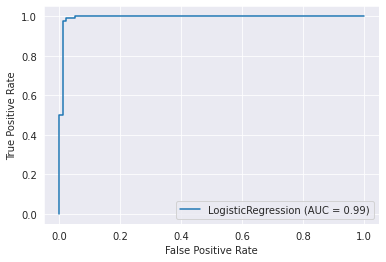

In [ ]:
# Plot the ROC
plot_roc_curve(logreg, X_test, y_test)

# 3. CAPM, Fama-French 3-factor model, Fama-French 5-factor model
https://randlow.github.io/posts/finance-economics/asset-pricing-regression/

In [ ]:
import statsmodels.formula.api as sm # module for stats models
from statsmodels.iolib.summary2 import summary_col # module for presenting stats models outputs nicely

In [ ]:
stock_data = "https://raw.githubusercontent.com/carlosfab/curso_data_science_na_pratica/master/modulo_02/BBAS3.SA.csv"
df_stk = pd.read_csv(stock_data, index_col='Date',parse_dates=True)

In [ ]:
df_stk.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-09-21,29.730000,30.580000,29.340000,30.580000,28.680056,16301600
2018-09-24,30.379999,30.700001,29.500000,29.730000,27.882866,13086900
2018-09-25,29.030001,29.760000,28.809999,29.549999,27.714045,11742900
2018-09-26,29.650000,29.969999,29.209999,29.450001,27.620264,12842400
2018-09-27,29.680000,30.299999,29.680000,30.290001,28.408072,8767900


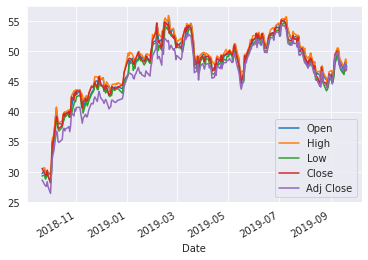

In [ ]:
df_stk.drop(['Volume'],axis=1,inplace=True)
df_stk.plot()

In [ ]:
def price2ret(prices,retType='simple'):
    if retType == 'simple':
        ret = (prices/prices.shift(1))-1
    else:
        ret = np.log(prices/prices.shift(1))
    return ret

In [ ]:
def assetPriceReg(df_stk):
    import pandas_datareader.data as web  # module for reading datasets directly from the web
    
    # Reading in factor data
    df_factors = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench')[0]
    df_factors.rename(columns={'Mkt-RF': 'MKT'}, inplace=True)
    df_factors['MKT'] = df_factors['MKT']/100
    df_factors['SMB'] = df_factors['SMB']/100
    df_factors['HML'] = df_factors['HML']/100
    df_factors['RMW'] = df_factors['RMW']/100
    df_factors['CMA'] = df_factors['CMA']/100
    
    df_stock_factor = pd.merge(df_stk,df_factors,left_index=True,right_index=True) # Merging the stock and factor returns dataframes together
    df_stock_factor['XsRet'] = df_stock_factor['Returns'] - df_stock_factor['RF'] # Calculating excess returns

    # Running CAPM, FF3, and FF5 models.
    CAPM = sm.ols(formula = 'XsRet ~ MKT', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    FF3 = sm.ols( formula = 'XsRet ~ MKT + SMB + HML', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})
    FF5 = sm.ols( formula = 'XsRet ~ MKT + SMB + HML + RMW + CMA', data=df_stock_factor).fit(cov_type='HAC',cov_kwds={'maxlags':1})

    CAPMtstat = CAPM.tvalues
    FF3tstat = FF3.tvalues
    FF5tstat = FF5.tvalues

    CAPMcoeff = CAPM.params
    FF3coeff = FF3.params
    FF5coeff = FF5.params

    # DataFrame with coefficients and t-stats
    results_df = pd.DataFrame({'CAPMcoeff':CAPMcoeff,'CAPMtstat':CAPMtstat,
                               'FF3coeff':FF3coeff, 'FF3tstat':FF3tstat,
                               'FF5coeff':FF5coeff, 'FF5tstat':FF5tstat},
    index = ['Intercept', 'MKT', 'SMB', 'HML', 'RMW', 'CMA'])


    dfoutput = summary_col([CAPM,FF3, FF5],stars=True,float_format='%0.4f',
                  model_names=['CAPM','FF3','FF5'],
                  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs)),
                             'Adjusted R2':lambda x: "{:.4f}".format(x.rsquared_adj)}, 
                             regressor_order = ['Intercept', 'MKT', 'SMB', 'HML', 'RMW', 'CMA'])

    print(dfoutput)
    
    return results_df

In [ ]:
df_stk['Returns'] = price2ret(df_stk[['Adj Close']])
df_stk = df_stk.dropna()
df_stk.head()

,Open,High,Low,Close,Adj Close,Returns
Date,,,,,,
2018-09-24,30.379999,30.700001,29.500000,29.730000,27.882866,-0.027796
2018-09-25,29.030001,29.760000,28.809999,29.549999,27.714045,-0.006055
2018-09-26,29.650000,29.969999,29.209999,29.450001,27.620264,-0.003384
2018-09-27,29.680000,30.299999,29.680000,30.290001,28.408072,0.028523
2018-09-28,29.830000,29.980000,29.299999,29.450001,27.620264,-0.027732


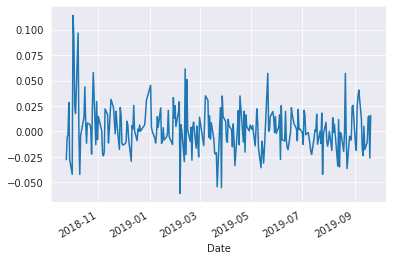

In [ ]:
df_stk['Returns'].plot()

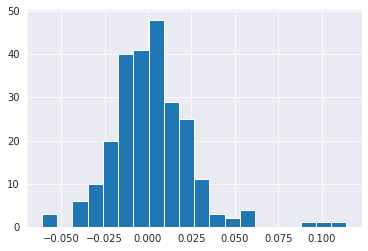

In [ ]:
df_stk['Returns'].hist(bins=20)

In [ ]:
df_regOutput = assetPriceReg(df_stk)


               CAPM       FF3        FF5    
--------------------------------------------
Intercept   -0.0068*** -0.0065*** -0.0067***
            (0.0015)   (0.0015)   (0.0015)  
MKT         0.4464***  0.5210***  0.6917*** 
            (0.1193)   (0.1283)   (0.1498)  
SMB                    0.2064     0.2474    
                       (0.2763)   (0.2786)  
HML                    0.4891**   0.1891    
                       (0.2439)   (0.2760)  
RMW                               -0.1909   
                                  (0.3845)  
CMA                               1.0858**  
                                  (0.5239)  
N           238        238        238       
Adjusted R2 0.0399     0.0554     0.0606    
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01


# 4. Predicting Bankruptcy using Logistic Regression


## 4.1. Data loading
The data consist of 64 financial ratio & 1 label (0 - no bankruptcy & 1 - bankruptcy after 5 years)

The NA values in data set were marked as "?" which will be imputed by 0 later.

List of attributes:

* X1 net profit / total assets
* X2 total liabilities / total assets
* X3 working capital / total assets
* X4 current assets / short-term liabilities
* X5 [(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365
* ...

More info: https://archive.ics.uci.edu/ml/datasets/Polish+companies+bankruptcy+data

In [ ]:
# Data loading
data_link = 'https://github.com/pnhuy/datasets/raw/master/polish_bankruptcy/1st_year.csv'
df_bankruptcy = pd.read_csv(data_link, na_values=['?'])

In [ ]:
df_bankruptcy.head()

,Attr1,Attr2,Attr3,Attr4,Attr5,Attr6,Attr7,Attr8,Attr9,Attr10,Attr11,Attr12,Attr13,Attr14,Attr15,Attr16,Attr17,Attr18,Attr19,Attr20,Attr21,Attr22,Attr23,Attr24,Attr25,Attr26,Attr27,Attr28,Attr29,Attr30,Attr31,Attr32,Attr33,Attr34,Attr35,Attr36,Attr37,Attr38,Attr39,Attr40,Attr41,Attr42,Attr43,Attr44,Attr45,Attr46,Attr47,Attr48,Attr49,Attr50,Attr51,Attr52,Attr53,Attr54,Attr55,Attr56,Attr57,Attr58,Attr59,Attr60,Attr61,Attr62,Attr63,Attr64,class
0,0.200550,0.37951,0.39641,2.0472,32.3510,0.38825,0.249760,1.33050,1.1389,0.50494,0.249760,0.65980,0.166600,0.249760,497.42,0.73378,2.6349,0.249760,0.149420,43.370,1.2479,0.21402,0.119980,0.47706,0.50494,0.60411,1.45820,1.7615,5.9443,0.11788,0.149420,94.14,3.8772,0.56393,0.21402,1.7410,593.2700,0.50591,0.128040,0.662950,0.051402,0.128040,114.42,71.050,1.00970,1.52250,49.394,0.185300,0.110850,2.0420,0.37854,0.25792,2.2437,2.2480,348690.0,0.121960,0.39718,0.87804,0.001924,8.4160,5.1372,82.658,4.4158,7.4277,0
1,0.209120,0.49988,0.47225,1.9447,14.7860,0.00000,0.258340,0.99601,1.6996,0.49788,0.261140,0.51680,0.158350,0.258340,677.96,0.53838,2.0005,0.258340,0.152000,87.981,1.4293,0.24806,0.123040,NaN,0.39542,0.43992,88.44400,16.9460,3.6884,0.26969,0.152000,122.17,2.9876,2.98760,0.20616,1.6996,NaN,0.49788,0.121300,0.086422,0.064371,0.145950,199.49,111.510,0.51045,1.12520,100.130,0.237270,0.139610,1.9447,0.49988,0.33472,17.8660,17.8660,2304.6,0.121300,0.42002,0.85300,0.000000,4.1486,3.2732,107.350,3.4000,60.9870,0
2,0.248660,0.69592,0.26713,1.5548,-1.1523,0.00000,0.309060,0.43695,1.3090,0.30408,0.312580,0.64184,0.244350,0.309060,794.16,0.45961,1.4369,0.309060,0.236100,73.133,1.4283,0.30260,0.189960,NaN,0.28932,0.37282,86.01100,1.0627,4.3749,0.41929,0.238150,176.93,2.0630,1.42740,0.31565,1.3090,2.3019,0.51537,0.241140,0.322020,0.074020,0.231170,165.51,92.381,0.94807,1.01010,96.372,0.291810,0.222930,1.0758,0.48152,0.48474,1.2098,2.0504,6332.7,0.241140,0.81774,0.76599,0.694840,4.9909,3.9510,134.270,2.7185,5.2078,0
3,0.081483,0.30734,0.45879,2.4928,51.9520,0.14988,0.092704,1.86610,1.0571,0.57353,0.092704,0.30163,0.094257,0.092704,917.01,0.39803,3.2537,0.092704,0.071428,79.788,1.5069,0.11550,0.062782,0.17193,0.57353,0.36152,0.94076,1.9618,4.6511,0.14343,0.071428,91.37,3.9948,0.37581,0.11550,1.3562,NaN,0.57353,0.088995,0.401390,0.069622,0.088995,180.77,100.980,0.28720,1.56960,84.344,0.085874,0.066165,2.4928,0.30734,0.25033,2.4524,2.4524,20545.0,0.054015,0.14207,0.94598,0.000000,4.5746,3.6147,86.435,4.2228,5.5497,0
4,0.187320,0.61323,0.22960,1.4063,-7.3128,0.18732,0.187320,0.63070,1.1559,0.38677,0.187320,0.33147,0.121820,0.187320,1133.20,0.32211,1.6307,0.187320,0.115530,57.045,NaN,0.19832,0.115530,0.18732,0.38677,0.32211,1.41380,1.1184,4.1424,0.27884,0.115530,147.04,2.4823,0.32340,0.19832,1.6278,11.2470,0.43489,0.122310,0.293040,0.096680,0.122310,141.62,84.574,0.73919,0.95787,65.936,0.188110,0.116010,1.2959,0.56511,0.40285,1.8839,2.1184,3186.6,0.134850,0.48431,0.86515,0.124440,6.3985,4.3158,127.210,2.8692,7.8980,0


In [ ]:
df_bankruptcy['class'].value_counts()

0    6756
1     271
Name: class, dtype: int64

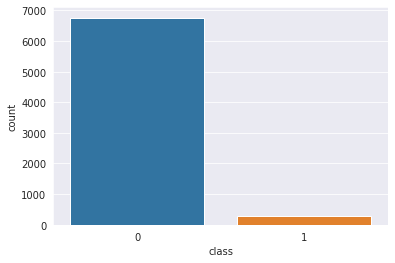

In [ ]:
sns.countplot(x="class", data=df_bankruptcy)

The distribution of label was extremely imbalanced

## 4.2. Data preprocessing

* NA filling by 0
* Standard scaling
* Train-test splitting


In [ ]:
# The NA in X dataframe was imputed by Zero
X = df_bankruptcy.drop(columns=['class']).fillna(0)
y = df_bankruptcy['class']

In [ ]:
# Scaling the features matrix by Standard scaling
scl = StandardScaler()
scl.fit(X)
X_scaled = scl.transform(X) 

In [ ]:
# Split the data into train and test dataset with the ratio 60:40
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y , test_size=0.4)

## 4.3. Hyperparameter Optimization using Grid Search

In [ ]:
# Initiate the Logistic Regression model
logreg = LogisticRegression()

In [ ]:
"""
Define the hyperparameter space
:params: penalty: Regularization method
:params: C: Regularization term, detail here: 
            https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
:params: solver: optimization algorithms
:params: class_weight: The “balanced” mode uses the values of y to automatically 
                       adjust weights inversely proportional to class frequencies 
                       in the input data as n_samples / (n_classes * np.bincount(y)).
"""
param_grid = {
    'penalty': ['l1', 'l2'], 
    'C': [-4, -2, -1, -0.5, 0.5, 1, 2, 4],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': ['balanced']
}

In [ ]:
# Initiate the Gridsearch with Cross-validation
grid = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc', verbose=True, n_jobs=-1)

In [ ]:
# Fit the data and hyperparameter space to the model 
# and benchmark to find out the best classifier
# ~ 5 min in Colab
best_clf = grid.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   59.8s finished


In [ ]:
# Showing the best params set
best_clf.best_params_

{'C': 2, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}

## 4.4. Results

In [ ]:
# Calculate the prediction in test set
y_pred = best_clf.predict(X_test)

In [ ]:
# Print the metrics on test set
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.70      0.82      2712
           1       0.08      0.68      0.14        99

    accuracy                           0.70      2811
   macro avg       0.53      0.69      0.48      2811
weighted avg       0.95      0.70      0.79      2811



In [ ]:
# Print the AUC score
y_score = best_clf.decision_function(X_test)
auc_score = roc_auc_score(y_test, y_score)
print(f"AUC = {auc_score}")

AUC = 0.7446217335597867


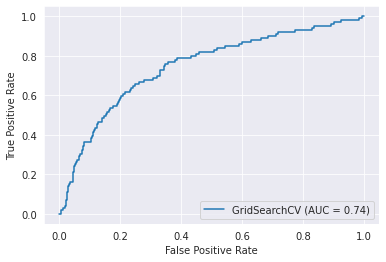

In [ ]:
# Plot the ROC 
plot_roc_curve(best_clf, X_test, y_test)